### 利用BS获得地铁线路

In [2]:
from bs4 import BeautifulSoup
from urllib import request

In [38]:
def getHTML(url):
	headers = {'User-Agent':
                   'User-Agent:Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'}
	req = request.Request(url, headers=headers)
	return request.urlopen(req)


def get_subway():
    url = "http://www.bjsubway.com/e/action/ListInfo/?classid=39&ph=1"
    content = getHTML(url).read()
    soup = BeautifulSoup(content, 'lxml')
    html = soup.select('div.con_text > table > tbody')
    stations = []
    for n in html:
        nn = n.select('tr > th:nth-of-type(1)')
        station = []
        for inn in nn:
            station.append(inn.text.strip())
        stations.append(station)
    return stations

In [39]:
stations = get_subway()

In [46]:
for i in stations:
    print(i)

['苹果园', '古城', '八角游乐园', '八宝山', '玉泉路', '五棵松', '万寿路', '公主坟', '军事博物馆', '木樨地', '南礼士路', '复兴门', '西单', '天安门西', '天安门东', '王府井', '东单', '建国门', '永安里', '国贸', '大望路', '四惠', '四惠东']
['西直门', '积水潭', '鼓楼大街', '安定门', '雍和宫', '东直门', '东四十条', '朝阳门', '建国门', '北京站', '崇文门', '前门', '和平门', '宣武门', '长椿街', '复兴门', '阜成门', '车公庄']
['天宫院', '生物医院基地', '义和庄', '黄村火车站', '黄村西大街', '清源路', '枣园', '高米店南', '高米店北', '西红门', '新宫', '公益西桥', '角门西', '马家堡', '北京南站', '陶然亭', '菜市口', '宣武门', '西单', '灵境胡同', '西四', '平安里', '新街口', '西直门', '动物园', '国家图书馆', '魏公村', '人民大学', '海淀黄庄', '中关村', '北京大学东门', '圆明园', '西苑', '北宫门', '安河桥北']
['宋家庄', '刘家窑', '蒲黄榆', '天坛东门', '磁器口', '崇文门', '东单', '灯市口', '东四', '张自忠路', '北新桥', '雍和宫', '和平里北街', '和平西桥', '惠新西街南口', '惠新西街北口', '大屯路东', '北苑路北', '立水桥南', '立水桥', '天通苑南', '天通苑', '天通苑北']
['金安桥', '苹果园', '杨庄', '西黄村', '廖公庄', '田村', '海淀五路居', '慈寿寺', '花园桥', '白石桥南', '车公庄西', '车公庄', '平安里', '北海北', '南锣鼓巷', '东四', '朝阳门', '东大桥', '呼家楼', '金台路', '十里堡', '青年路', '褡裢坡', '黄渠', '常营', '草房', '物资学院路', '通州北关', '通运门', '北运河西', '北运河东', '郝家府', '东夏园', '潞城']
['北京西站', '湾子', '达官营', '广安门内',

In [10]:
from collections import defaultdict,Counter
import networkx as nx
import matplotlib.pyplot as plt

In [41]:
# 获得相邻的站点
def get_connection(subway):
    dicts = defaultdict(list)
    for i in subway:
        for k,v in enumerate(i):
            if k > 0 and k < len(i)-1:
                dicts[v].append(i[k-1])
                dicts[v].append(i[k+1])
            elif k == 0:
                dicts[v].append(i[k+1])
            else:
                dicts[v].append(i[k-1])
    return dicts

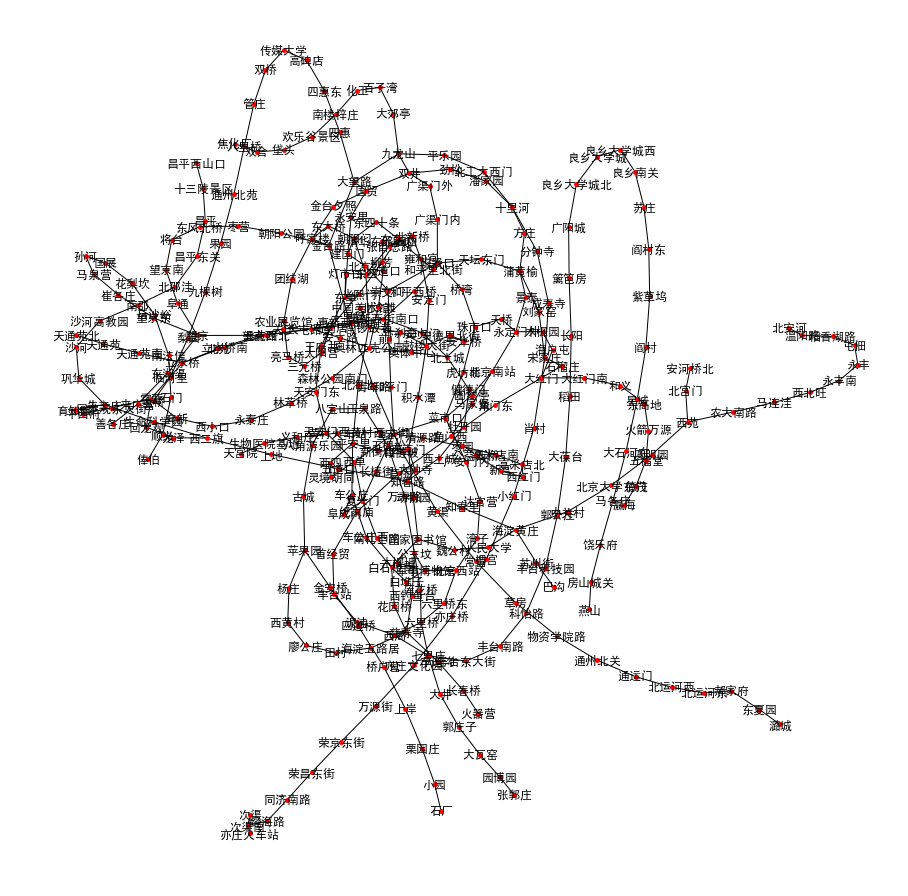

In [42]:
connections = get_connection(stations)
subway_graph = nx.Graph(connections)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(3,figsize=(12,12))
nx.draw(subway_graph, pos = nx.spring_layout(subway_graph), with_labels=True, node_size=15)

In [20]:
def get_station_line():
    line = defaultdict(list)
    for k,v in enumerate(stations):
        for iv in v:
            line[iv].append(k)
    return line

In [44]:
station_line= get_station_line() # 存放的是这个站属于哪条线，用于计算换乘次数
print(station_line['北京西站'])
print(station_line['苹果园'])
print(station_line['人民大学'])
print(station_line['五道口'])

[5, 8]
[0, 4]
[2, 18]
[10]


In [27]:
# 简易计算换乘次数，比较这次和下一个站点的第一个是不是同一条线路
def get_change_times(path):
    times = 0
    line_list = []
    for p in path: line_list.append(station_line[p][0])
    for x,y in enumerate(line_list):
        if x < (len(line_list)-1) and y!= line_list[x+1]: times+= 1
    return times

In [57]:
# 综合考虑，换乘时间加每站乘坐时间
def comprehensive_priority(path):
    station_time = len(path) * 2
    change_time = get_change_times(path) * 10
    part_time = station_time + change_time
    return part_time

In [28]:
def is_goal(dest):
    def _wrap(cur_path):
        return cur_path[-1] == dest
    return _wrap

In [146]:
def search_subway(start, dest, search_strategy, by_way=None):
    pathes = [[start]]
    seen = set()
    choice_path = []
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]
        if frontier in seen: continue
        successor = connections[frontier]
        for station in successor:
            if station in path: continue
            new_path = path + [station]
#             print(new_path)
            if station == dest:
                if by_way == None:
                    choice_path.append(new_path) 
                else:
                    have_byway = [n for n in new_path if n in by_way]
                    if have_byway == by_way:
                        choice_path.append(new_path)
            else:pathes.append(new_path)
        pathes = search_strategy(pathes)
        seen.add(frontier)
#     print(choice_path)
#     if len(choice_path)>1:
#         choice_path = search_strategy(choice_path)
    return choice_path

In [137]:
def sort_path(cmp_func, beam=-1):
    def _sorted(pathes):
        return sorted(pathes, key = cmp_func)[:beam]
    return _sorted

### 输出是所有满足条件的路径，第一个是最佳路径

In [153]:
print(search_subway(start='人民大学',dest='五道口',search_strategy = lambda n:n, by_way=None))

[['人民大学', '海淀黄庄', '知春里', '知春路', '五道口'], ['人民大学', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '安贞门', '惠新西街南口', '芍药居', '望京西', '北苑', '立水桥', '霍营', '回龙观', '龙泽', '西二旗', '上地', '五道口']]


In [152]:
print(search_subway(start='人民大学',dest='五道口',search_strategy = sort_path(get_change_times, beam=10), by_way=None))

[['人民大学', '海淀黄庄', '知春里', '知春路', '五道口'], ['人民大学', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '森林公园南门', '林萃桥', '永泰庄', '西小口', '育新', '霍营', '回龙观东大街', '平西府', '育知路', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口']]


In [151]:
print(search_subway(start='人民大学',dest='五道口',search_strategy = sort_path(comprehensive_priority, beam=10), by_way=['牡丹园']))

[['人民大学', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '森林公园南门', '林萃桥', '永泰庄', '西小口', '育新', '霍营', '回龙观', '龙泽', '西二旗', '上地', '五道口']]


In [147]:
print(search_subway(start='圆明园',dest='五道口',search_strategy = sort_path(get_change_times,beam=10), by_way=['北京大学东门','知春里']))

[['圆明园', '北京大学东门', '中关村', '海淀黄庄', '知春里', '知春路', '五道口'], ['圆明园', '北京大学东门', '中关村', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '森林公园南门', '林萃桥', '永泰庄', '西小口', '育新', '霍营', '回龙观东大街', '平西府', '育知路', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口']]


In [149]:
print(search_subway(start='巩华城',dest='立水桥',search_strategy = lambda n: n, by_way=['牡丹园']))

[['巩华城', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口', '知春路', '西土城', '牡丹园', '健德门', '北土城', '安贞门', '惠新西街南口', '芍药居', '望京西', '北苑', '立水桥']]


In [150]:
print(search_subway(start='圆明园',dest='五道口',search_strategy = sort_path(comprehensive_priority,beam=10), by_way=['北京大学东门','知春里']))

[['圆明园', '北京大学东门', '中关村', '海淀黄庄', '知春里', '知春路', '五道口'], ['圆明园', '北京大学东门', '中关村', '海淀黄庄', '知春里', '知春路', '西土城', '牡丹园', '健德门', '北土城', '奥体中心', '奥林匹克公园', '森林公园南门', '林萃桥', '永泰庄', '西小口', '育新', '霍营', '回龙观东大街', '平西府', '育知路', '朱辛庄', '生命科学园', '西二旗', '上地', '五道口']]
